In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
class MLQPLayer(tf.keras.layers.Layer):
    def __init__(self, n_outputs):
        super(MLQPLayer, self).__init__()
        self.n_outputs = n_outputs

    def build(self, input_shape):
        self.mu = self.add_weight('mu', shape=[int(input_shape[-1]), self.n_outputs])
        self.nu = self.add_weight('nu', shape=[int(input_shape[-1]), self.n_outputs])
        self.bias = self.add_weight('bias', shape=[1, self.n_outputs])

    def call(self, inputs, *args, **kwargs):
        return tf.matmul(inputs*inputs, self.mu) + tf.matmul(inputs, self.nu) + self.bias

In [33]:
learning_rate = 0.1
training_epochs = 5000
display_step = 100
n_idle_epochs = 1000
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=n_idle_epochs, min_delta=0.00001)

def scheduler(epoch, lr):
    if lr <= 0.01:
        return lr
    if epoch % 200 == 0:
        return lr * 0.8
        # return lr * 0.9   # best
    else:
        return lr
reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

class NEPOCHLogger(tf.keras.callbacks.Callback):
    def __init__(self, per_epoch=100):
        super(NEPOCHLogger, self).__init__()
        self.seen = 0
        self.per_epoch = per_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.per_epoch == 0:
            print('Epoch {}, loss {:.8f}, train_accuracy {:.8f}'.format(epoch, logs['loss'], logs['acc']))

log_display = NEPOCHLogger(per_epoch=display_step)
train_data = pd.read_csv(r'two_spiral_train_data.txt', header=None, sep='\s+')
test_data = pd.read_csv(r'two_spiral_test_data.txt', header=None, sep='\s+')
train_data['class_0'] = train_data[2].apply(lambda x: 1 if x == 0 else 0)
train_data['class_1'] = train_data[2].apply(lambda x: 1 if x == 1 else 0)
test_data['class_0'] = test_data[2].apply(lambda x: 1 if x == 0 else 0)
test_data['class_1'] = test_data[2].apply(lambda x: 1 if x == 1 else 0)

train_X = tf.convert_to_tensor(np.asarray(train_data.iloc[:, 0:2]))
train_y = tf.convert_to_tensor(np.asarray(train_data.iloc[:, 2]))
test_X = tf.convert_to_tensor(np.asarray(test_data.iloc[:, 0:2]))
test_y = tf.convert_to_tensor(np.asarray(test_data.iloc[:, 2]))

model = tf.keras.Sequential([
    MLQPLayer(128),
    tf.keras.layers.Activation('swish'),
    MLQPLayer(2),
    tf.keras.layers.Activation('softmax')
])

optimizer = tf.keras.optimizers.SGD(learning_rate)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [34]:
history = model.fit(train_X, train_y, epochs=training_epochs, verbose=0, batch_size=16, callbacks=[log_display, reduce_lr])
print("Train Finished!", history)
y_hat_train = model.predict(train_X, verbose=0)
y_hat_test = model.predict(test_X, verbose=0)
print('total number of test samples: %d' % len(test_y))
print(model.evaluate(test_X, test_y, verbose=0))

Epoch 0, loss 4.59731340, train_accuracy 0.47000000
Epoch 100, loss 0.44294760, train_accuracy 0.78666669
Epoch 200, loss 0.33562708, train_accuracy 0.81999999
Epoch 300, loss 0.27564260, train_accuracy 0.88333333
Epoch 400, loss 0.19286422, train_accuracy 0.94333333
Epoch 500, loss 0.12308178, train_accuracy 0.97000003
Epoch 600, loss 0.06706067, train_accuracy 0.99666667
Epoch 700, loss 0.04995204, train_accuracy 0.99333334
Epoch 800, loss 0.03064198, train_accuracy 0.99666667
Epoch 900, loss 0.02350839, train_accuracy 1.00000000
Epoch 1000, loss 0.02284825, train_accuracy 1.00000000
Epoch 1100, loss 0.02072449, train_accuracy 1.00000000
Epoch 1200, loss 0.01363365, train_accuracy 1.00000000
Epoch 1300, loss 0.01128835, train_accuracy 1.00000000
Epoch 1400, loss 0.00984603, train_accuracy 1.00000000
Epoch 1500, loss 0.00846500, train_accuracy 1.00000000
Epoch 1600, loss 0.00777211, train_accuracy 1.00000000
Epoch 1700, loss 0.00747528, train_accuracy 1.00000000
Epoch 1800, loss 0.006

NameError: name 'model' is not defined

In [ ]:
class_0_area, class_1_area = {}, {}
for x in np.arange(-6, 6.1, 0.5):
    for y in np.arange(-6, 6.1, 0.5):
        if model.predict([[x, y]], verbose=0)[0][0] < 0.5:
            class_1_area.setdefault('x', []).append(x)
            class_1_area.setdefault('y', []).append(y)
        else:
            class_0_area.setdefault('x', []).append(x)
            class_0_area.setdefault('y', []).append(y)

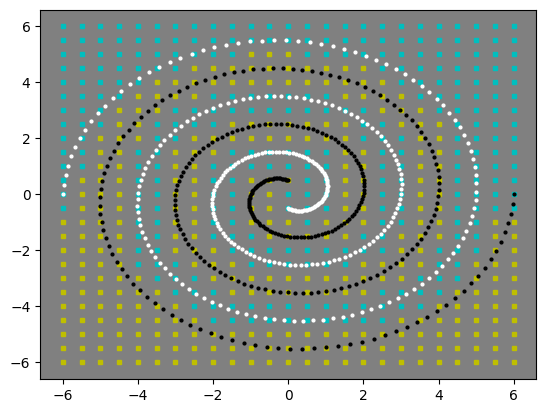

In [36]:
class_0, class_1 = {}, {}
for X, y in zip(np.concatenate([train_X.numpy(), test_X.numpy()], 0), np.concatenate([train_y.numpy(), test_y.numpy()], 0)):
    if y == 0:
        class_0.setdefault('x', []).append(X[0])
        class_0.setdefault('y', []).append(X[1])
    else:
        class_1.setdefault('x', []).append(X[0])
        class_1.setdefault('y', []).append(X[1])
plt.axes().set_facecolor('gray')
plt.plot(class_0_area['x'], class_0_area['y'], 'cs', markersize=3, label='class 0 area')
plt.plot(class_1_area['x'], class_1_area['y'], 'ys', markersize=3, label='class 1 area')
plt.plot(class_0['x'], class_0['y'], 'wo', markersize=2, label='class 0')
plt.plot(class_1['x'], class_1['y'], 'o', markersize=2, color='#000000', label='class 1')
plt.show()